# How to use the initial conditions

In this tutorial you learn about the initial conditions and how you can use them to create realistic distributions of infected and immune individuals at the start of a simulation.

## Explanation

Briefly, the initial conditions allow you to shape the distribution of initial infections and immunity in the population. You can

- set the number of initial infections. 
- increase the number of infections by some factor to reduce underreporting, for example, due to asymptomatic cases. You can also keep shares between subgroups constant.
- let infections evolve over some periods to have courses of diseases in every stage.
- assume pre-existing immunity in the population.

In scenarios where many individuals have already been infected and the disease has spread across the population for a longer time, courses of the diseases are more heterogenous. Thus, you should start a simulation with some kind of "warm-start". That is what the initial conditions are for.

The ``initial_conditions`` can be passed to the [get_simulate_func](../autoapi/sid/index.rst#sid.get_simulate_func). It is a dictionary with the following keys.

```python
initial_conditions = {
    "assort_by": None,
    "burn_in_periods": 14,
    "growth_rate":  1.3,
    "initial_infections": 0.05,
    "initial_immunity": None,
    "known_cases_multiplier": 1.3
}
```

The entries have the following meaning:

- ``"initial_infections"`` is used to set the initial infections in the population. You can use an integer for the number of infected people, a float between 0 and 1 for the share and a series with values for each person. 

- ``ìnitial_immunity`` can be given as an integer or a float identical to ``initial_infections`` to allow for pre-existing immunity in the population. Note that infected individuals are also immune. For a 10% pre-existing immunity with 2% currently infected people, set the key to 0.12. By default, ``initial_immunity`` is ``None`` which means no pre-existing immunity.
    
- ``"known_cases_multiplier"`` can be used to scale the infections indicated by ``initial_infections``. Normally, the number of initial infections relies on official resources which only cover the known, tested cases instead of the real number of infections. Assuming a asymptotic course of disease in a third of cases, the gap between the known cases and the real number of cases can be substantial.

- ``"assort_by"`` can be a variable name or a list of variable names which are used to form groups via ``.groupby``. While scaling the number of infections with the ``"known_cases_multiplier"``, the relative share of infections between groups stays the same.

- ``"burn_in_periods"`` is the number of days or periods during which infections are started. The shorter the burn-in period the lesser heterogenous the pattern is.

- ``"growth_rate"`` is the exponential growth rate which governs the occurrence of infections over the burn-in periods. For example, a growth rate of two leads to a duplication of infections for every day of the burn-in period.


## Example

### Preparation

Now, let us visualize the effects of the initial conditions. Note that the following example uses internal functions of sid which are not part of the public API and, thus, are not guaranteed to be stable and should not be used in general.

For the example, we need to generate some inputs which are explained below.

In [34]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sid

First, we get the epidemiological parameters from sid.

In [2]:
params = sid.load_epidemiological_parameters()

Next, we create artifical individuals which belong to an age group and a region.

In [3]:
n_people = 100_000
seed = itertools.count()

available_ages = [
    "0-9",
    "10-19",
    "20-29",
    "30-39",
    "40-49",
    "50-59",
    "60-69",
    "70-79",
    "80-100",
]

ages = np.random.choice(available_ages, size=n_people)
regions = np.random.choice(["North", "East", "South", "West"], size=n_people)
states = pd.DataFrame({"age_group": ages, "region": regions}).astype("category")

# Early processing of states and drawing courses of diseases which is necessary for
# the following exploration. Does not need to be used by users in general.
states = sid.simulate._process_initial_states(
    states, {0: ["age_group", "region"]}, {"names": ["base_strain"]}
)
states = sid.pathogenesis.draw_course_of_disease(states, params, next(seed))

Now, we want to specify the initial conditions and assume that 24% of individuals are infected. Furthermore, initial infections should strongly vary by regions. ``"North"`` and ``"South"`` have twice as many infections as ``"East"`` and ``"West"``. We assume that the actual number of infected individuals is 20% higher and infection number should be preserved between regions. We also require that infections double every day over a period of 14 days.

In [4]:
n_infections = 24_000
prob = n_infections / n_people
prob_high = prob * 4 / 3
prob_low = prob * 2 / 3

probabilities = states["region"].replace(
    {"North": prob_high, "South": prob_high, "East": prob_low, "West": prob_low}
)
initial_infections = np.random.uniform(0, 1, size=len(probabilities)) <= probabilities
initial_infections = pd.Series(initial_infections)

In [5]:
initial_conditions = {
    "initial_infections": initial_infections,
    "initial_immunity": None,
    "known_cases_multiplier": 1.2,
    "assort_by": "region",
    "growth_rate": 2,
    "burn_in_periods": 14,
}

At last, we apply the function which handles the initial conditions and changes the states.

In [6]:
default_virus_strains = sid.parse_model.parse_virus_strains(None, params=params)

parsed_initial_conditions = sid.parse_model.parse_initial_conditions(
    initial_conditions,
    start_date_simulation=pd.Timestamp("2021-07-01"),
    virus_strains=default_virus_strains,
)

states = sid.initial_conditions.sample_initial_distribution_of_infections_and_immunity(
    states=states,
    params=params,
    initial_conditions=parsed_initial_conditions,
    seed=seed,
    testing_demand_models={},
    testing_allocation_models={},
    testing_processing_models={},
    virus_strains=default_virus_strains,
    vaccination_models={},
    derived_state_variables={},
)

### Analysis

Next, we analyze the impact of the initial conditions. First, let us look at the total number of infections. We started with 24,000 infections and increased the number by 20% which are roughly 28,800 infections.

In [11]:
states["ever_infected"].sum()

28965

We wanted to preserve the regional differences in positive cases where North and South have twice the infections of East and West.

In [30]:
states.groupby("region")["ever_infected"].mean().round(2)

region
East     0.19
North    0.39
South    0.38
West     0.19
Name: ever_infected, dtype: float64

Lastly, we wanted infections to increase every day by a factor of 2.

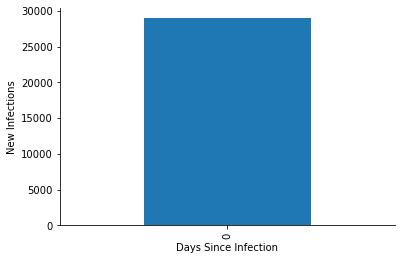

In [41]:
fig, ax = plt.subplots(figsize=(6, 4))

infections_by_day = states.query("ever_infected").groupby("cd_ever_infected").size()
infections_by_day.index = -1 * infections_by_day.index

infections_by_day.plot(kind="bar", ax=ax)

ax.set_ylabel("New Infections")
ax.set_xlabel("Days Since Infection")

sns.despine()
plt.show()